In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import scipy.stats as st

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [2]:
data = pd.read_csv("input/data-attendance-3.txt")

In [3]:
data

,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1
5,1,0,69,B,1
6,1,0,69,C,0
7,1,0,69,B,1
8,1,0,69,A,1
9,1,0,69,A,1


In [4]:
data.groupby("Weather").sum()

,PersonID,A,Score,Y
Weather,,,,
A,30374,585,154071,953
B,17883,335,89705,500
C,9767,194,50588,269


### 背景知識の変換

晴れ：曇り：雨　= 0:0.2:1

## モデル式
$$ logit_i = b_1 + b_2 * A_i + b_3 * Score_i + b_4 * Weather_i$$
$$Y_i = Bernoulli(logit_i)$$

In [5]:
def model(a, score, weather, y):
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    b3 = pyro.sample("b3", dist.Normal(0, 10))
    b4 = pyro.sample("b4", dist.Normal(0, 10))

    logits = b1 + b2 * a + b3 * score + b4 * weather
    with pyro.plate("data", len(a)):
        pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

In [6]:
a = torch.tensor(data.A.values).float()
score = torch.tensor(data.Score.values).float() / 200.
weather = torch.tensor(data.Weather.replace("A", 0).replace("B", 0.2).replace("C", 1).values).float()
y = torch.tensor(data.Y.values).float()

In [7]:
hmc_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
mcmc_posterior = MCMC(hmc_kernel, num_samples=1000, num_chains=4, warmup_steps=1000).run(a, score, weather, y)

In [8]:
sites = ["b1", "b2", "b3", "b4"]
mcmc_samples = mcmc_posterior.marginal(sites).support(flatten=True)
mcmc_df = pd.DataFrame(EmpiricalMarginal(mcmc_posterior, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).cpu().numpy(), columns=sites)

In [9]:
df_stats = mcmc_df.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T
df_stats["mean"] = mcmc_df.mean(0)
df_stats

,0.025,0.25,0.5,0.75,0.975,mean
b1,-0.274952,0.031744,0.167909,0.331172,0.634292,0.178348
b2,-0.814725,-0.686887,-0.627944,-0.563370,-0.436579,-0.627307
b3,1.229434,1.691650,1.960377,2.189338,2.676269,1.951386
b4,-0.708354,-0.548504,-0.463376,-0.377044,-0.222588,-0.463190


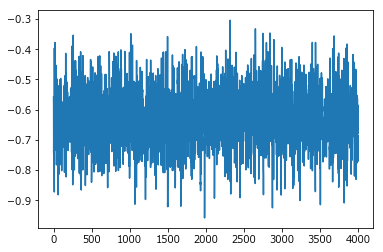

In [10]:
mcmc_df.b2.plot()

In [11]:
def predict_model(a, score, weather):
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    b3 = pyro.sample("b3", dist.Normal(0, 10))
    b4 = pyro.sample("b4", dist.Normal(0, 10))

    logits = b1 + b2 * a + b3 * score + b4 * weather
    pyro.sample("y", dist.Bernoulli(logits=logits))

In [12]:
predictive_distribution = TracePredictive(predict_model, mcmc_posterior, num_samples=1000).run(a, score, weather)

In [13]:
y_samples = EmpiricalMarginal(predictive_distribution, "y")._get_samples_and_weights()[0].numpy().mean(0)

In [14]:
def sigmoid(a):
    s = 1 / (1 + np.exp(-a))
    return s
a = sigmoid(mcmc_df.b1.values.reshape(-1, 1) \
+ mcmc_df.b2.values.reshape(-1, 1) * 0 \
+ np.dot(mcmc_df.b3.values.reshape(-1, 1), np.arange(30, 200).reshape(1, -1) / 200) \
+ mcmc_df.b4.values.reshape(-1, 1) * 0)

In [15]:
area = pd.DataFrame(a).quantile([0.1, 0.9])

/Users/makora/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


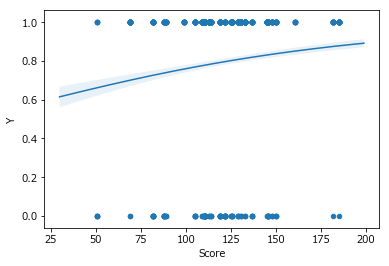

In [16]:
tmp = data[data.A ==0][data.Weather=="A"]
tmp.plot(kind='scatter', x="Score", y="Y")
plt.plot(range(30, 200), a.mean(0))
plt.fill_between(range(30, 200), area.loc[0.1], area.loc[0.9], alpha=0.1)

In [17]:
a = sigmoid(mcmc_df.b1.values.reshape(-1, 1) \
+ mcmc_df.b2.values.reshape(-1, 1) * data.A.values.reshape(1, -1) \
+ np.dot(mcmc_df.b3.values.reshape(-1, 1), data.Score.values.reshape(1, -1)/200) \
+ mcmc_df.b4.values.reshape(-1, 1) * data.Weather.replace("A", 0).replace("B", 0.2).replace("C", 1).values.reshape(1, -1))

In [34]:
 tmp_df = pd.DataFrame([])
tmp_df["q_i"] = pd.DataFrame(a).quantile(0.5)


{'bodies': [<matplotlib.collections.PolyCollection at 0x14c14cdd8>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x14c3ac240>,
 'cmins': <matplotlib.collections.LineCollection at 0x14c156588>,
 'cbars': <matplotlib.collections.LineCollection at 0x14c156828>}

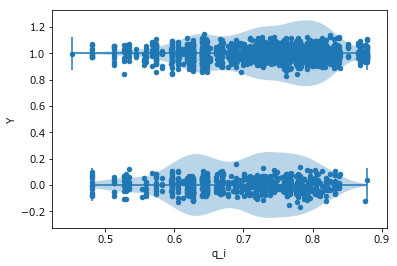

In [41]:
tmp_df["Y"] = data.Y + np.random.normal(loc=0, scale=0.05, size=len(data.Y))
tmp_df.plot(kind="scatter", x="q_i", y="Y")

tmp_df["Y"] = data.Y
plt.violinplot([tmp_df[tmp_df.Y==0]["q_i"].values, tmp_df[tmp_df.Y==1]["q_i"].values], [0, 1], vert=False)

In [50]:
from sklearn.metrics import auc, roc_curve

In [51]:
fpr, tpr, thresholds = roc_curve(tmp_df.Y.values, tmp_df.q_i.values)
auc_score = auc(fpr, tpr)

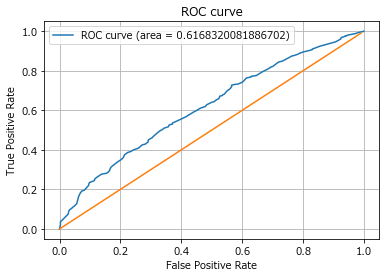

In [52]:
plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(auc_score))
plt.plot(np.arange(0,1, 0.01), np.arange(0,1, 0.01))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)